<a href="https://colab.research.google.com/github/Clarkpriestly/My-Projects/blob/main/Brain_Tumor_Classification_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')
ireneausnyame_test_csv_path = kagglehub.dataset_download('ireneausnyame/test-csv')

print('Data source import complete.')


# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Check if CUDA is available (for GPU acceleration)
if torch.cuda.is_available():  # Check if CUDA is available
    device = 'cuda'  # Set device to CUDA
    print("Using CUDA")
else:
    device = 'cpu'  # Set device to CPU
    print("Using CPU")

Using CUDA


In [ ]:
#!ls
#!unzip brain_tumor.zip


In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.classes = sorted(entry.name for entry in os.scandir(img_dir) if entry.is_dir())  # List and sort class names from img_dir
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes)}  # Map class names to numeric labels
        self.filepaths = []
        self.labels = []
        for class_name in self.classes:
            class_path = os.path.join(img_dir, class_name)  # Construct path to each class folder
            for img_name in os.listdir(class_path):  # Loop over images in the class folder
                img_path = os.path.join(class_path, img_name)  # Build full image path
                self.filepaths.append(img_path)
                self.labels.append(self.class_to_idx[class_name])  # Append corresponding label

    def __len__(self):
        return len(self.filepaths)  # Return total number of images

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]
        image = Image.open(self.filepaths[idx]).convert("RGB")  # Load image and convert to RGB
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)


In [ ]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.RandomRotation(degrees= 10),  # Apply random rotation
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomAffine(degrees = 10,
                      translate= (0.05, 0.05),
                      scale= (0.95, 1.0),
                      shear= 0),  # Apply affine transformations: translate, shear, scale
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])  # Normalize with standard mean and std
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])  # Normalize
])

# Define transformations for viewing original images (just to tensor)
no_aug_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])  # Normalize
])

In [ ]:

print(os.listdir('/kaggle/input/brain-tumor-mri-dataset'))  # Check top-level directory

['Training', 'Testing']


In [ ]:
# Create datasets and dataloaders
training_dataset = BrainTumorDataset(img_dir='/kaggle/input/brain-tumor-mri-dataset/Training', transform=no_aug_transforms)
testing_dataset = BrainTumorDataset(img_dir= '/kaggle/input/brain-tumor-mri-dataset/Testing', transform=val_transforms)

# Calculate the sizes of the training and validation sets
test_size = int(0.7 * len(testing_dataset))  # Calculate 70% of testing_dataset
val_size = len(testing_dataset) - test_size  # Remaining 30%

# Split the dataset
test_dataset, val_dataset = random_split(testing_dataset, lengths = [test_size, val_size])  # Split testing_dataset into test and validation sets
print(len(test_dataset), len(val_dataset))

# Create DataLoaders
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names and number of classes
class_names = training_dataset.classes
num_classes = len(class_names)
print("Class Names:", class_names)
print("Number of Classes:", num_classes)
print(f"Number of Training set: {len(training_dataset)}")
print(f"Number of Validation set: {len(val_dataset)}")
print(f"Number of Test set: {len(test_dataset)}")

917 394
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of Classes: 4
Number of Training set: 5712
Number of Validation set: 394
Number of Test set: 917


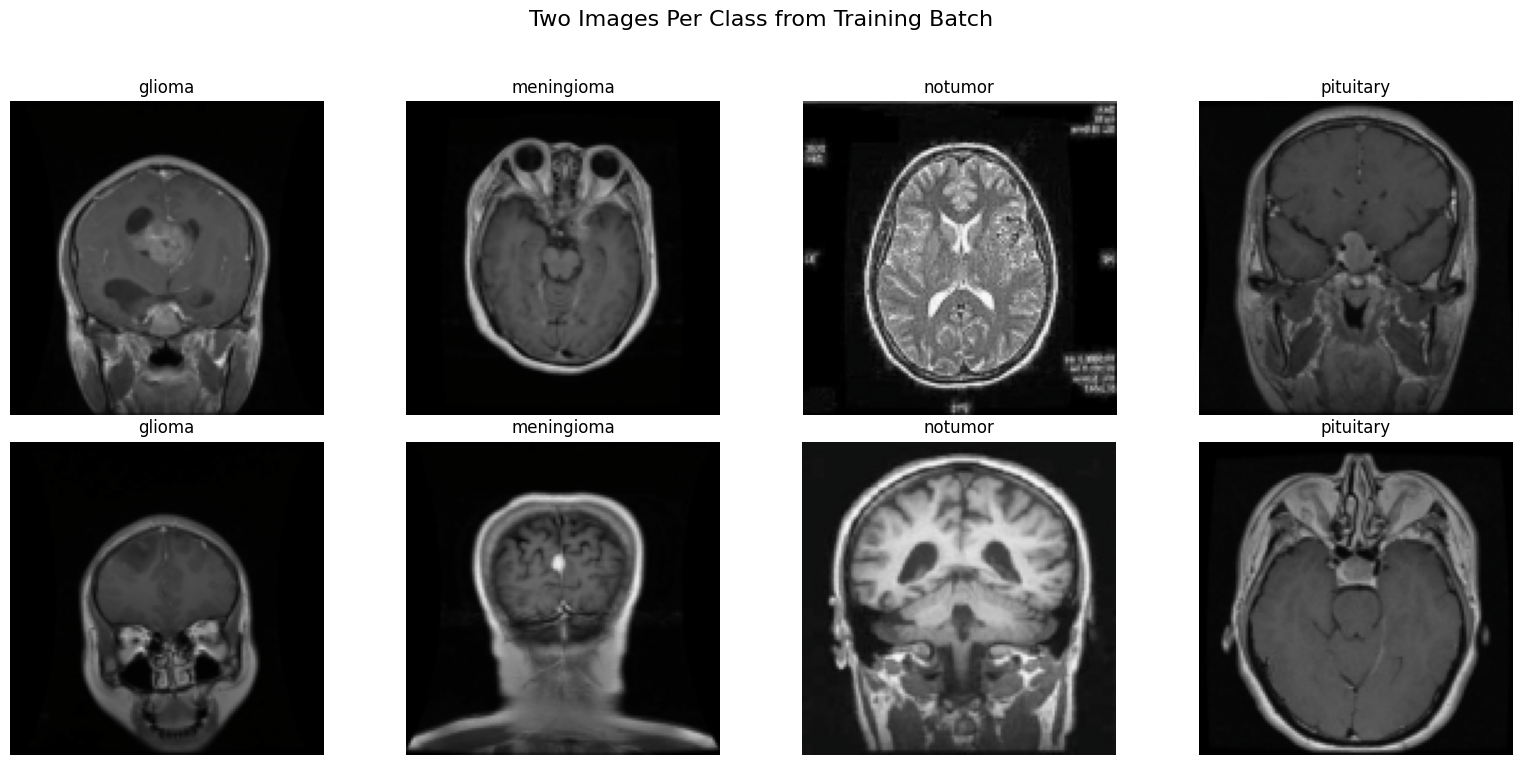

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of data from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Function to reverse normalization (if applied)
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Number of images to show per class per column
images_per_class = 2

# Create a dictionary to store images for each class
class_images = {class_name: [] for class_name in training_dataset.classes}

# Iterate through the first batch and store images by their class
for i in range(len(labels)):
    label_index = labels[i].item()
    class_name = training_dataset.classes[label_index]
    if len(class_images[class_name]) < images_per_class:
        class_images[class_name].append(images[i])

# Filter out classes that don't have the desired number of images in this batch
class_images = {k: v for k, v in class_images.items() if len(v) == images_per_class}

# Number of classes to display
num_classes_to_show = len(class_images)

if num_classes_to_show > 0:
    fig, axes = plt.subplots(images_per_class, num_classes_to_show, figsize=(4 * num_classes_to_show, 4 * images_per_class))
    fig.suptitle("Two Images Per Class from Training Batch", fontsize=16)

    col_index = 0
    for class_name, img_list in class_images.items():
        for row_index, img_tensor in enumerate(img_list):
            ax = axes[row_index, col_index]
            ax.imshow(denormalize(img_tensor))
            ax.set_title(class_name)
            ax.axis('off')
        col_index += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
else:
    print("Not enough classes with at least two images in the first batch to display.")

In [ ]:
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()

        # Apply BatchNorm to the input image
        self.bn0 = nn.BatchNorm2d(3)

        # First Convolutional Block
        # TODO: Define Conv2d layer: in_channels=3, out_channels=32, kernel_size=3, padding=1
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # TODO: Define BatchNorm2d for 32 channels
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.20)

        # Second Convolutional Block
        # TODO: Define Conv2d layer: in_channels=32, out_channels=64, kernel_size=3, padding=1
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # TODO: Define BatchNorm2d for 64 channels
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.20)

        # Third Convolutional Block
        # TODO: Define Conv2d layer: in_channels=64, out_channels=128, kernel_size=5, padding=2
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, padding = 2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # TODO: Define BatchNorm2d for 128 channels
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()

        # Fully Connected Layers
        # TODO: Define Linear layer: input features=128*18*18, output=256
        self.fc1 = nn.Linear(128*16*16, 256)
        self.relu4 = nn.ReLU()
        # TODO: Define BatchNorm1d for 256 features
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.25)

        # TODO: Define Linear layer: input=256, output=128
        self.fc2 = nn.Linear(256, 128)
        self.relu5 = nn.ReLU()
        # TODO: Define BatchNorm1d for 128 features
        self.bn5 = nn.BatchNorm1d(128)
        self.dropout5 = nn.Dropout(0.25)

        # TODO: Define Linear layer: input=128, output=64
        self.fc3 = nn.Linear(128, 64)
        self.relu6 = nn.ReLU()
        # TODO: Define BatchNorm1d for 64 features
        self.bn6 = nn.BatchNorm1d(64)

        # TODO: Final output layer: Linear from 64 to num_classes
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Apply batch normalization to the input
        x = self.bn0(x)
        # Apply first convolutional block:
        x = self.conv1(x)# 1. Convolution
        x = self.relu1(x)# 2. ReLU activation
        x = self.pool1(x)# 3. Max pooling
        x = self.bn1(x)# 4. Batch normalization
        x = self.dropout1(x)# 5. Dropout

        # Apply second convolutional block:
        x = self.conv2(x)# 1. Convolution
        x = self.relu2(x)# 2. ReLU activation
        x = self.pool2(x)# 3. Max pooling
        x = self.bn2(x)# 4. Batch normalization
        x = self.dropout2(x)# 5. Dropout

        # Apply third convolutional block:
        x = self.conv3(x)# 1. Convolution with larger kernel size
        x = self.relu3(x)# 2. ReLU activation
        x = self.pool3(x)# 3. Max pooling
        x = self.bn3(x)# 4. Batch normalization
        x = self.dropout3(x)# 5. Dropout

        # Flatten the feature maps into a 1D tensor
        x = self.flatten(x)
        #x = x.view(-1, 128*18*18)
        # Pass through first fully connected block:
        x = self.fc1(x)# 1. Linear layer
        x = self.relu4(x)# 2. ReLU activation
        x = self.bn4(x)# 3. Batch normalization
        x = self.dropout4(x)# 4. Dropout

        # Pass through second fully connected block:
        x = self.fc2(x)# 1. Linear layer
        x = self.relu5(x)# 2. ReLU activation
        x = self.bn5(x)# 3. Batch normalization
        x = self.dropout5(x)# 4. Dropout

        # Pass through third fully connected block:
        x = self.fc3(x)# 1. Linear layer
        x = self.relu6(x)# 2. ReLU activation
        x = self.bn6(x)# 3. Batch normalization

        # Final output layer to predict class scores
        x = self.fc4(x)
        return x

# Example use
num_classes = 4
model = BrainTumorClassifier(num_classes).to(device)
print(model)


BrainTumorClassifier(
  (bn0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
# Defining Hyperparameters

#batch_size = 32
num_epochs = 10   # Set the number of epochs
learning_rate = 0.001

In [ ]:
# Applying transformation
#training_dataset.dataset.transform = train_transforms
#testing_dataset.dataset.transform = val_transforms

# Creating dataloaders
#train_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle = True)
#test_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
# Define the loss function:
# Use a suitable loss function for multi-class classification (e.g., CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()
# Define the optimizer:
# Choose an optimizer (e.g., Adam) and set an appropriate learning rate
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Reset gradients

        # TODO: Perform forward pass and store outputs
        outputs = model(inputs)

        # TODO: Calculate the loss between outputs and labels
        loss = criterion(outputs, labels)

        # TODO: Perform backpropagation and update model weights
        loss.backward()
        optimizer.step()

        # Update running_loss
        running_loss += loss.item() * inputs.size(0)

        # TODO: Get predictions from outputs
        _, predicted = torch.max(outputs, 1)

        # TODO: Update total_samples and correct_predictions
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate and print epoch metrics
    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

print("Training finished.")

Epoch [1/10], Loss: 0.5286, Accuracy: 0.8062
Epoch [2/10], Loss: 0.3558, Accuracy: 0.8706
Epoch [3/10], Loss: 0.3090, Accuracy: 0.8880
Epoch [4/10], Loss: 0.2432, Accuracy: 0.9135
Epoch [5/10], Loss: 0.2225, Accuracy: 0.9172
Epoch [6/10], Loss: 0.2184, Accuracy: 0.9186
Epoch [7/10], Loss: 0.1992, Accuracy: 0.9266
Epoch [8/10], Loss: 0.1426, Accuracy: 0.9489
Epoch [9/10], Loss: 0.1746, Accuracy: 0.9359
Epoch [10/10], Loss: 0.1336, Accuracy: 0.9520
Training finished.


              precision    recall  f1-score   support

      glioma       0.89      0.98      0.93       205
  meningioma       0.95      0.82      0.88       217
     notumor       0.96      0.99      0.98       277
   pituitary       0.98      0.99      0.99       218

    accuracy                           0.95       917
   macro avg       0.95      0.94      0.94       917
weighted avg       0.95      0.95      0.95       917



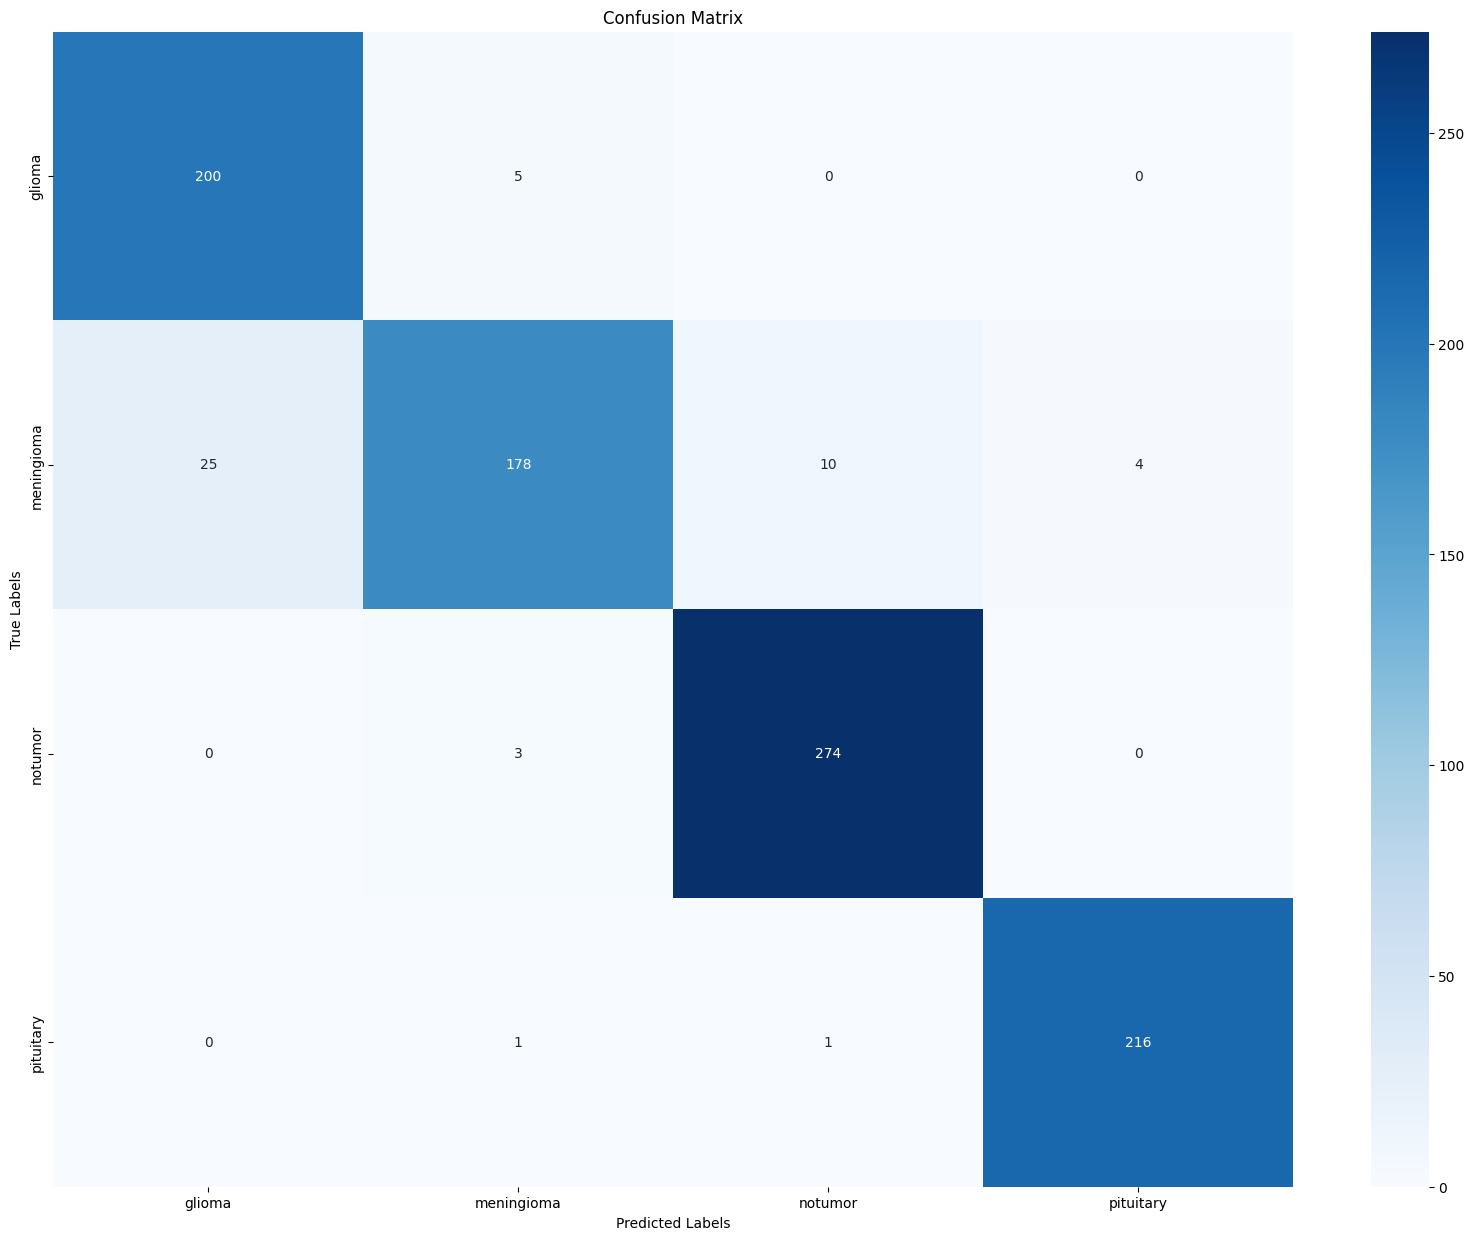

In [ ]:
model.eval()  # Set model to evaluation mode
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # TODO: Perform model inference to get outputs
        outputs = model(inputs)

        # TODO: Get predicted class from outputs
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Use class names from the dataset
class_labels = class_names

# TODO: Print classification report using all_labels and all_predictions
print(classification_report(all_labels, all_predictions, target_names = class_labels, zero_division=1.0))

# TODO: Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# TODO: Visualize confusion matrix using seaborn heatmap
plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.eval()  # Set to evaluation mode

# Define the same transforms you used for validation
test_transforms = val_transforms

def find_image_path(root_dir, image_name):
    # Check all subdirectories for the image
    for subdir in ['glioma', 'meningioma', 'notumor', 'pituitary', 'Testing']:
        potential_path = os.path.join(root_dir, subdir, image_name)
        if os.path.exists(potential_path):
            return potential_path
    raise FileNotFoundError(f"Image {image_name} not found in any subdirectory")

# Create a dataset class that uses the CSV file and searches subfolders
class CSVDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]  # Get image filename from CSV
        img_path = find_image_path(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name  # Return image and filename


# Paths to your data
csv_file = "/kaggle/input/test-csv/test.csv"
root_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Create test dataset and dataloader
test_dataset = CSVDataset(csv_file, root_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Make predictions and prepare submission
predictions = []
image_names = []

with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.cpu().numpy())
        image_names.extend(names)

# Create submission
submission_df = pd.DataFrame({
    'image_name': image_names,
    'label': predictions
})

submission_df.to_csv(F'submission({num_epochs}).csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv


Author: Ireneaus Nyame